<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a><br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

# Primary vs Consolidated

The purpose of this notebook is to see how different primary exchange prices vs consolidated prices are, and what percentage of trading occurs on the primary exchange.

In [1]:
from quantrocket import get_prices
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
def compare_dbs(primary_db, consolidated_db, start_date, universes=None):
    """
    Compare the primary and consolidated db, and return a tuple of scalars: 
    primary volume as a percentage of consolidated volume, how often the 
    closing price differs by more than 1%, and how often the opening price
    differs by more than 1%.
    """
    prices_p = get_prices(primary_db, universes=universes, fields=["Close","Open","Volume"], start_date=start_date)
    prices_c = get_prices(consolidated_db, universes=universes, fields=["Close","Open","Volume"], start_date=start_date)
    shared_columns = prices_p.columns.intersection(prices_c.columns)
    prices_p = prices_p[shared_columns]
    prices_c = prices_c[shared_columns]
    
    volumes_p = prices_p.loc["Volume"].sum(axis=1)
    volumes_c = prices_c.loc["Volume"].sum(axis=1)
    volumes_p.name = "primary"
    volumes_c.name = "consolidated"
    primary_volume_pct = (1 - (volumes_c-volumes_p)/volumes_c)
    # primary volume sometimes exceeds consolidated volume for Japan stocks, which doesn't make sense; ignore those
    primary_volume_pct = primary_volume_pct.where(primary_volume_pct <= 1)
    primary_volume_pct = primary_volume_pct.mean()
    
    closes_p = prices_p.loc["Close"]
    closes_c = prices_c.loc["Close"]
    closes_pct_diff = ((closes_p-closes_c).abs()/closes_p.where(closes_p > 0))
    closes_differ_alot = (closes_pct_diff > 0.01).astype(int)
    closes_differ_alot = (closes_differ_alot.stack().sum()/closes_differ_alot.stack().count())
    
    opens_p = prices_p.loc["Open"]
    opens_c = prices_c.loc["Open"]
    opens_pct_diff = ((opens_p-opens_c).abs()/opens_p.where(opens_p > 0))
    opens_differ_alot = (opens_pct_diff > 0.01).astype(int)
    opens_differ_alot = (opens_differ_alot.stack().sum()/opens_differ_alot.stack().count())

    return primary_volume_pct, closes_differ_alot, opens_differ_alot

Countries for which numbers should be run:

In [3]:
countries = (
    ("usa-stk-1d", "United States"),
    ("canada-stk-1d", "Canada"),
    ("australia-stk-1d", "Australia"),
    ("japan-stk-1d", "Japan"),
    ("spain-stk-1d", "Spain"),
    ("netherlands-stk-1d", "Netherlands"),
    ("uk-stk-1d", "United Kingdom"),
    ("germany-stk-1d", "Germany"),
    ("france-stk-1d", "France"),
    ("belgium-stk-1d", "Belgium"),
    ("swiss-stk-1d", "Switzerland"),
)

Countries where there is no difference between primary and consolidated but which should still be included in the chart:

In [4]:
countries_no_difference = (
    "Austria",
    "Sweden",
    "Hong Kong",
    "Singapore",
    "Italy",
    "Mexico",
)

Run numbers for each country:

In [5]:
primary_volume_pct = {}
prices_differ_alot = {}
start_date = "2018-01-01"

for db_basename, country in countries:
    volume, closes, opens = compare_dbs(primary_db=db_basename+"-p", consolidated_db=db_basename, start_date=start_date)
    primary_volume_pct[country] = volume
    prices_differ_alot[country] = {"Open":opens, "Close":closes}
    
for country in countries_no_difference:
    primary_volume_pct[country] = 1
    prices_differ_alot[country] = {"Open":0, "Close":0}

Generate plots. First, prices:

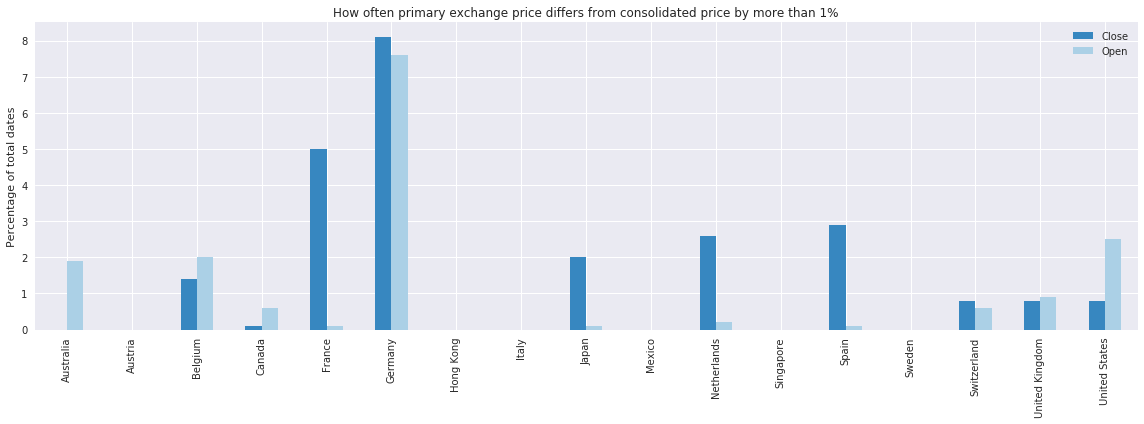

In [6]:
sns.set_palette(sns.color_palette("Blues_r", n_colors=2))
prices = pd.DataFrame(prices_differ_alot).T.round(3)*100
ax = prices.sort_index().plot(kind="bar", title="How often primary exchange price differs from consolidated price by more than 1%", figsize=(16,6))
ax.set_ylabel("Percentage of total dates")
plt.tight_layout()

Then volume:

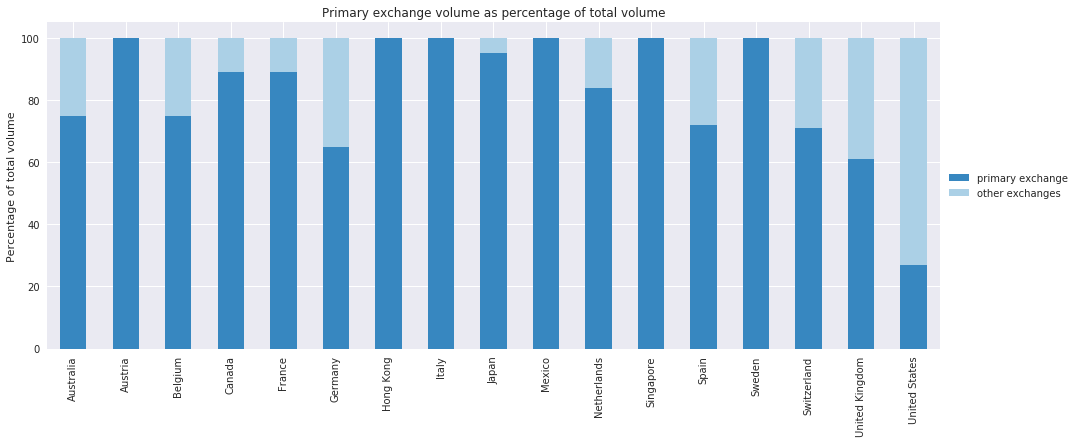

In [7]:
sns.set_palette(sns.color_palette("Blues_r", n_colors=2))
primary_volumes = pd.Series(primary_volume_pct).round(2) * 100
primary_volumes = primary_volumes.sort_index()
primary_volumes.name = "primary exchange"
other_volumes = 100 - primary_volumes
other_volumes.name = "other exchanges"
volumes = pd.concat([primary_volumes, other_volumes], axis=1)
ax = volumes.plot(kind="bar", stacked=True, title="Primary exchange volume as percentage of total volume", figsize=(16,6))
ax.set_ylabel("Percentage of total volume")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

***

[Back to Introduction](Introduction.ipynb)